<center>
    <h1>Machine Learning for Economists Winter 2020/21</h1>
    <h3>Februrary 5th, 2021</h3>
</center>

# Lab 8: Multi-Armed Bandits
_By Mario Müller & Pascal Budner_

<img src="https://upload.wikimedia.org/wikipedia/commons/8/82/Las_Vegas_slot_machines.jpg" width="300px" />

Consider a two-armed bandit problem with 1000 sequential draws where rewards are either 0 or 1. For arm a, P (y = 1|D = a) ≡ pa denotes the probability of the reward being equal to 1.

In [2]:
# first, importing some libraries
import statsmodels.stats.api as sms # used to calculate power stuff
import seaborn as sns # used for visualization purposes
import matplotlib.pyplot as plt # used for visualization purposes
import numpy as np # used to argmax array
import random # used to draw random numbers

# set parameters
T = 1000 # number of sequentials draws during a single Multi-armed bandit game
no_of_simulations = 2000 # number of simulation executions

# seaborn theme
sns.set_theme(style="darkgrid", color_codes=True)
sns.set_context('paper')

## 1. Classic Randomized Experiment
Suppose that p1 = .05 and p2 = .1. If you ran a classic randomized experiment, how many observations would you need to sample into each treatment arm to detect a difference between arm 1 and arm 2 at a two-sided significance level of .99 and with power of .8? Adjust the code from the lecture notes to find out. Also, what would be the regret?

### Calculate the Number of Needed Observations


In [3]:
# set some parameters
p_1 = 0.05
p_2 = 0.1
significane_lvl = 0.01
power = 0.8

# First, calculate the number of observations we need to detect 
# a difference between both arms with power of 0.8 and two-sided
# significance level of 0.99
es = sms.proportion_effectsize(p_1, p_2) # calculate effect size comparing two proportions
num_of_needed_obs = sms.NormalIndPower().solve_power(es, power=power, alpha=significane_lvl, ratio=1) # returns number of observations per sample
print("We need to sample {:.0f} obversations per treatment arm.".format(num_of_needed_obs))

We need to sample 631 obversations per treatment arm.


### Calculate the Regret


In [4]:
# doing a randomized experiment we would in num_of_needed_obs times 
# play the wrong arm (i.e., arm 1). Hence, we miss the p_2 - p_1 chance
# of getting a reward
regret = (p_2 - p_1) * num_of_needed_obs
print("The regret is {:.0f} before we realize which arm is better at a power of {} and p<{}.".format(regret, power, significane_lvl))

The regret is 32 before we realize which arm is better at a power of 0.8 and p<0.01.


## 2. Introducing the Multi-Armed Bandit Setting
Instead, you decide to conduct experimentation using a multi-armed bandit setting. To find out how the bandit setting will fare in comparison to the randomized experiment, we simulate the bandit setting many times. The simulation requires
-  A function that takes random draws from the rewards distribution
- A rule that prescribes which arm we try next. As a simple benchmark rule, implement greedy action selection as discussed in the lecture notes.

Simulate cumulative rewards over 1000 draws by setting up a loop that

1. prescribes which arm to try next (via some action selection rule)
2. pulls the arm
3. and stores the realized reward

Note that due to the stochastic nature of payoffs, cumulative rewards will look different each time you run the loop. Run the loop 2000 times and plot the average cumulative reward. (Hint: You need to write an outer loop over the number of simulations, and you need to store cumulative rewards each round.)

Average Reward is 83.2485


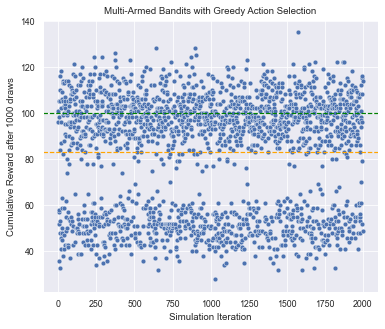

In [11]:
# this function draws the reward from a discrete random distribution
# the parameter p specifies the proability to retrieve the reward
def draw_from_distribution(p):
  # draw random number (uniformely distributed between [0.0,1.0])
  if random.random() <= p: # if random number is smaller then p we won and retrieve reward
    return 1
  return 0

# select arm based on highest expected reward
def greedy_action_selector(expected_reward_per_arm):
  if min(expected_reward_per_arm) == max(expected_reward_per_arm): # we have no superior arm found yet
    d_t = random.randint(0,len(expected_reward_per_arm)-1) # pick randomly one of the arms
  else:
    d_t = np.argmax(expected_reward_per_arm) # pick arm with highest expected reward
  return d_t

def play_bandit_game(num_of_draws, p_array, action_selector):
  p = p_array # reward probability for arms
  cumulative_rewards = [0.0] * len(p_array) # init to 0.0 per arm (float)
  number_of_times_arm_chosen = [0.0] * len(p_array) # init to 0 per arm
  expected_reward_per_arm = [0.0] * len(p_array) # init to 0 per arm
  
  # play bandit game num_of_draws times
  for i in range(num_of_draws):
    # select which arm to choose, by using the one with the highest expected revenue
    d_t = action_selector(expected_reward_per_arm)
    
    # play arm, retrieve reward, and update variables
    reward = draw_from_distribution(p[d_t])
#    print("#{} – Played arm {} and retrieved a reward of {}.".format(i+1, d_t+1, reward))
    cumulative_rewards[d_t] += reward # update cumulative reward
    number_of_times_arm_chosen[d_t] += 1 # increase number of times arm played

    # update expected reward for selected arm
    expected_reward_per_arm[d_t] = cumulative_rewards[d_t] / number_of_times_arm_chosen[d_t]
  return sum(cumulative_rewards)

def simulate_bandit_game(p_array, action_selector):
  # play the mutli-armed bandit game no_of_simulations times and save each received reward
  rewards = []

  # execute the bandit game no_of_simulations times
  for iteration in range(no_of_simulations):
    rewards.append(play_bandit_game(T, p_array, greedy_action_selector))
  return rewards

# play the bandits game with greedy action selection
p_array = [p_1, p_2]
rewards = simulate_bandit_game(p_array, greedy_action_selector)

# visualize results
average_reward = sum(rewards)/len(rewards)
print('Average Reward is {}'.format(average_reward))
plt.figure(figsize=(6,5))
graph = sns.scatterplot(data=rewards)
graph.axes.axhline(max(p_array) * T, color='green', linestyle='--') # expected reward if we would always choose the best arm
graph.axes.axhline(average_reward, color='orange', linestyle='--') # average reward of our sample
plt.xlabel('Simulation Iteration');
plt.ylabel('Cumulative Reward after {} draws'.format(T));
plt.title('Multi-Armed Bandits with Greedy Action Selection');

## 3. ε-greddy Algorithm Implementation
Write a function epsGreedy that implements the ε-greedy algorithm. Compare the performance of
the ε-greedy algorithm to the greedy algorithm from part 2 for ε ∈ {.1, .3}.

Average Reward for Standard Greedy Action Selection is 83.834
Average Reward for ε-Greedy Action Selection (ε = 0.1) is 83.6565
Average Reward for ε-Greedy Action Selection (ε = 0.3) is 84.0345


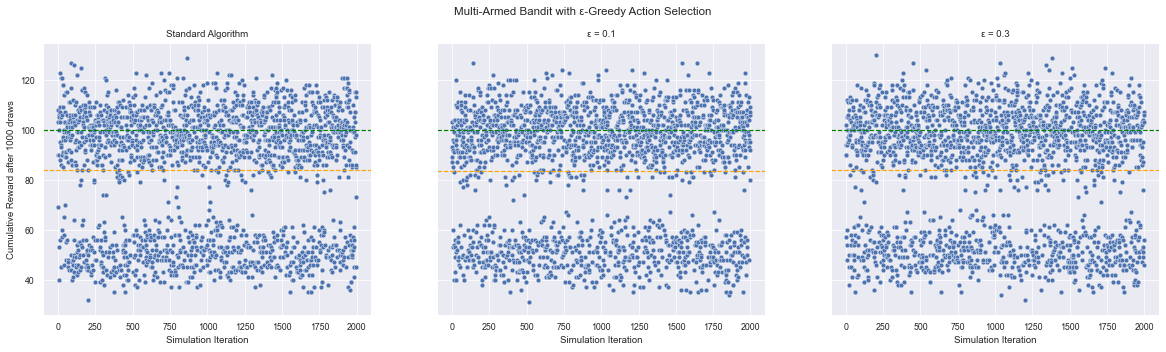

In [12]:
# select arm based on highest expected reward
def epsilon_greedy_action_selector(expected_reward_per_arm, epsilon):
  random_pick = random.randint(0,len(expected_reward_per_arm)-1)

  # draw random number (uniformely distributed between [0.0,1.0])
  if random.random() <= epsilon: # if epsilon is smaller, then we just pick a random guess
    return random_pick

  # otherwise we apply our greedy action selection algorithm 
  return greedy_action_selector(expected_reward_per_arm)

# visualize results
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
fig.suptitle('Multi-Armed Bandit with ε-Greedy Action Selection')

p_array = [p_1, p_2]

# greedy action selection
rewards = simulate_bandit_game(p_array, lambda x: greedy_action_selector(x))
average_reward = sum(rewards)/len(rewards)
print('Average Reward for Standard Greedy Action Selection is {}'.format(average_reward))
sns.scatterplot(ax=axes[0], data=rewards)
axes[0].axhline(max(p_array) * T, color='green', linestyle='--') # expected reward if we would always choose the best arm
axes[0].axhline(average_reward, color='orange', linestyle='--') # average reward of our sample
axes[0].set_title('Standard Algorithm')
axes[0].set_ylabel('Cumulative Reward after {} draws'.format(T))
axes[0].set_xlabel('Simulation Iteration')


# first e-greedy game
epsilon = 0.1
rewards = simulate_bandit_game(p_array, lambda x: epsilon_greedy_action_selector(x, epsilon))
average_reward = sum(rewards)/len(rewards)
print('Average Reward for ε-Greedy Action Selection (ε = {}) is {}'.format(epsilon, average_reward))
sns.scatterplot(ax=axes[1], data=rewards)
axes[1].axhline(max(p_array) * T, color='green', linestyle='--') # expected reward if we would always choose the best arm
axes[1].axhline(average_reward, color='orange', linestyle='--') # average reward of our sample
axes[1].set_title('ε = {}'.format(epsilon))
axes[1].set_ylabel('Cumulative Reward after {} draws'.format(T))
axes[1].set_xlabel('Simulation Iteration')

# second e-greedy game
epsilon = 0.3
rewards = simulate_bandit_game(p_array, lambda x: epsilon_greedy_action_selector(x, epsilon))
average_reward = sum(rewards)/len(rewards)
print('Average Reward for ε-Greedy Action Selection (ε = {}) is {}'.format(epsilon, average_reward))
sns.scatterplot(ax=axes[2], data=rewards)
axes[2].axhline(max(p_array) * T, color='green', linestyle='--') # expected reward if we would always choose the best arm
axes[2].axhline(average_reward, color='orange', linestyle='--') # average reward of our sample
axes[2].set_title('ε = {}'.format(epsilon))
axes[2].set_ylabel('Cumulative Reward after {} draws'.format(T))
_ = axes[2].set_xlabel('Simulation Iteration')

## 4. Sensitivity of ε-greddy Algorithm
Explore how the results for the epsilon greedy algorithm change when the reward distributions for
the two arms are very different, in particular, set p2 = .5, and compare again ε = .1 to ε = .3.

Average Reward for Standard Greedy Action Selection is 455.601
Average Reward for ε-Greedy Action Selection (ε = 0.1) is 454.876
Average Reward for ε-Greedy Action Selection (ε = 0.3) is 459.9225


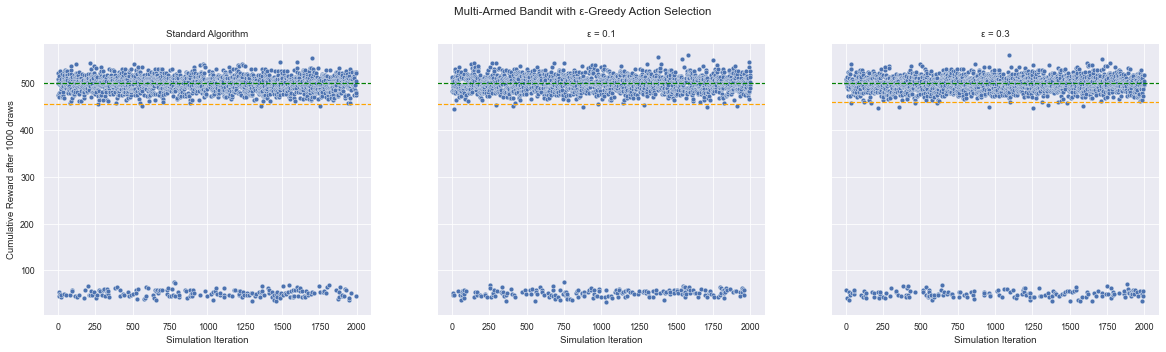

In [13]:
p_2_new = 0.5
p_array = [p_1, p_2_new]

# visualize results
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
fig.suptitle('Multi-Armed Bandit with ε-Greedy Action Selection')

# greedy action selection
rewards = simulate_bandit_game(p_array, lambda x: greedy_action_selector(x))
average_reward = sum(rewards)/len(rewards)
print('Average Reward for Standard Greedy Action Selection is {}'.format(average_reward))
sns.scatterplot(ax=axes[0], data=rewards)
axes[0].axhline(max(p_array) * T, color='green', linestyle='--') # expected reward if we would always choose the best arm
axes[0].axhline(average_reward, color='orange', linestyle='--') # average reward of our sample
axes[0].set_title('Standard Algorithm')
axes[0].set_ylabel('Cumulative Reward after {} draws'.format(T))
axes[0].set_xlabel('Simulation Iteration')


# first e-greedy game
epsilon = 0.1
rewards = simulate_bandit_game(p_array, lambda x: epsilon_greedy_action_selector(x, epsilon))
average_reward = sum(rewards)/len(rewards)
print('Average Reward for ε-Greedy Action Selection (ε = {}) is {}'.format(epsilon, average_reward))
sns.scatterplot(ax=axes[1], data=rewards)
axes[1].axhline(max(p_array) * T, color='green', linestyle='--') # expected reward if we would always choose the best arm
axes[1].axhline(average_reward, color='orange', linestyle='--') # average reward of our sample
axes[1].set_title('ε = {}'.format(epsilon))
axes[1].set_ylabel('Cumulative Reward after {} draws'.format(T))
axes[1].set_xlabel('Simulation Iteration')

# second e-greedy game
epsilon = 0.3
rewards = simulate_bandit_game(p_array, lambda x: epsilon_greedy_action_selector(x, epsilon))
average_reward = sum(rewards)/len(rewards)
print('Average Reward for ε-Greedy Action Selection (ε = {}) is {}'.format(epsilon, average_reward))
sns.scatterplot(ax=axes[2], data=rewards)
axes[2].axhline(max(p_array) * T, color='green', linestyle='--') # expected reward if we would always choose the best arm
axes[2].axhline(average_reward, color='orange', linestyle='--') # average reward of our sample
axes[2].set_title('ε = {}'.format(epsilon))
axes[2].set_ylabel('Cumulative Reward after {} draws'.format(T))
_ = axes[2].set_xlabel('Simulation Iteration')

## 5. Increasing the Number of Bandits
Explore how results change when you increase the number of bandits by using p1 =.05, p2 =.1, p3 =.01, p4 = .11, p5 = .4. Compare again ε = .1 to ε = .3.

Average Reward for Standard Greedy Action Selection is 275.818
Average Reward for ε-Greedy Action Selection (ε = 0.1) is 273.904
Average Reward for ε-Greedy Action Selection (ε = 0.3) is 270.665


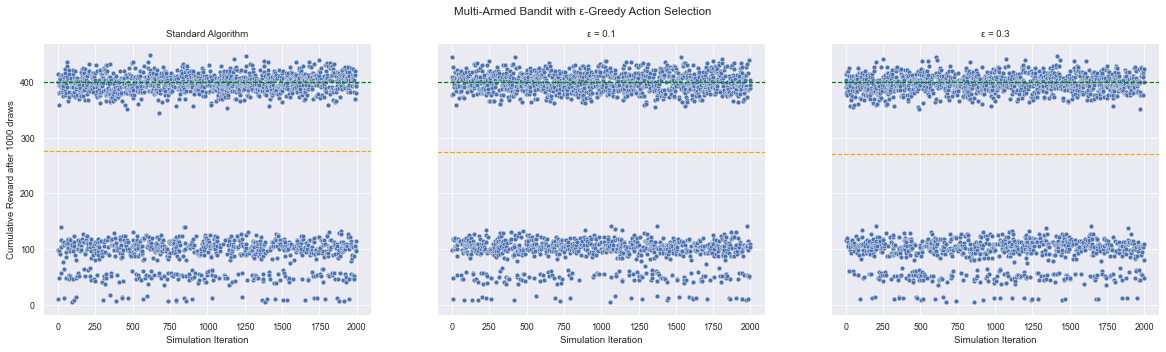

In [14]:
p_array = [0.05, 0.1, 0.01, 0.11, 0.4]

# visualize results
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
fig.suptitle('Multi-Armed Bandit with ε-Greedy Action Selection')

# greedy action selection
rewards = simulate_bandit_game(p_array, lambda x: greedy_action_selector(x))
average_reward = sum(rewards)/len(rewards)
print('Average Reward for Standard Greedy Action Selection is {}'.format(average_reward))
sns.scatterplot(ax=axes[0], data=rewards)
axes[0].axhline(max(p_array) * T, color='green', linestyle='--') # expected reward if we would always choose the best arm
axes[0].axhline(average_reward, color='orange', linestyle='--') # average reward of our sample
axes[0].set_title('Standard Algorithm')
axes[0].set_ylabel('Cumulative Reward after {} draws'.format(T))
axes[0].set_xlabel('Simulation Iteration')


# first e-greedy game
epsilon = 0.1
rewards = simulate_bandit_game(p_array, lambda x: epsilon_greedy_action_selector(x, epsilon))
average_reward = sum(rewards)/len(rewards)
print('Average Reward for ε-Greedy Action Selection (ε = {}) is {}'.format(epsilon, average_reward))
sns.scatterplot(ax=axes[1], data=rewards)
axes[1].axhline(max(p_array) * T, color='green', linestyle='--') # expected reward if we would always choose the best arm
axes[1].axhline(average_reward, color='orange', linestyle='--') # average reward of our sample
axes[1].set_title('ε = {}'.format(epsilon))
axes[1].set_ylabel('Cumulative Reward after {} draws'.format(T))
axes[1].set_xlabel('Simulation Iteration')

# second e-greedy game
epsilon = 0.3
rewards = simulate_bandit_game(p_array, lambda x: epsilon_greedy_action_selector(x, epsilon))
average_reward = sum(rewards)/len(rewards)
print('Average Reward for ε-Greedy Action Selection (ε = {}) is {}'.format(epsilon, average_reward))
sns.scatterplot(ax=axes[2], data=rewards)
axes[2].axhline(max(p_array) * T, color='green', linestyle='--') # expected reward if we would always choose the best arm
axes[2].axhline(average_reward, color='orange', linestyle='--') # average reward of our sample
axes[2].set_title('ε = {}'.format(epsilon))
axes[2].set_ylabel('Cumulative Reward after {} draws'.format(T))
_ = axes[2].set_xlabel('Simulation Iteration')